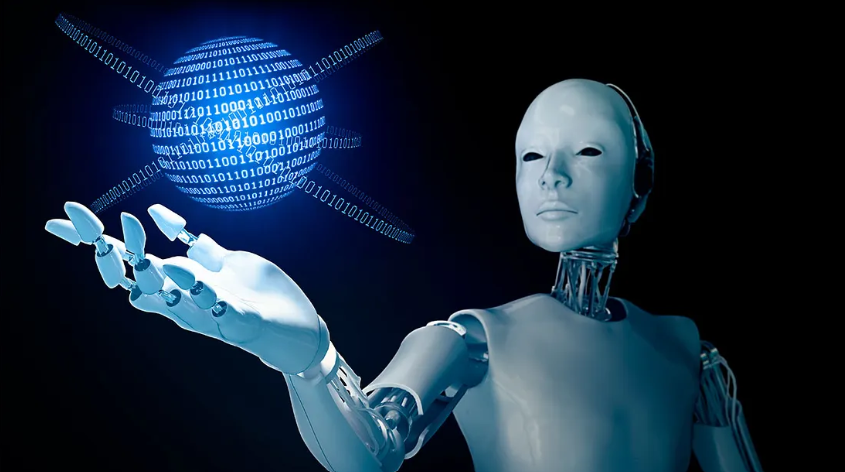

<div style="background-color:#ffffff; padding:20px; border-radius:12px; border:1px solid #99ccff;">
  <h2 style="margin:0; color:#000000; text-align:center;">Why This Competition?</h2>
  <p style="margin-top:15px; font-size:18px; color:#000000; line-height:1.6; text-align:center;">
    Scientific images often shape global research findings — but image manipulation threatens that trust.  
    This competition aims to build AI systems that can detect copy-move forgeries in biomedical figures, ensuring the credibility of published science.  
    By developing accurate segmentation models, participants contribute to research integrity, helping journals and institutions verify authenticity automatically.  
    It’s not just about accuracy — it’s about protecting truth in scientific discovery.
  </p>
</div>


In [ ]:


import numpy as np 
import pandas as pd 


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



<div style="background:linear-gradient(90deg,#00c9a7,#92fe9d); padding:10px; border-radius:8px; text-align:center; margin-top:15px;"> <h2 style="margin:0; color:#222;"> Import Libraries </h2>

In [ ]:
import os
import cv2
import json
import torch
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
import albumentations as A
import matplotlib.pyplot as plt
import torch.nn.functional as F

from PIL import Image
from tqdm import tqdm
from collections import defaultdict
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import MaskRCNN
from sklearn.model_selection import train_test_split
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F_transforms

import warnings
warnings.filterwarnings('ignore')

# Checking GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

<div style="background:linear-gradient(90deg,#00c9a7,#92fe9d); padding:10px; border-radius:8px; text-align:center; margin-top:15px;"> <h2 style="margin:0; color:#222;"> Checking Image Sizes in CV Tasks</h2> </div> <div style="background:#f8faff; border:1px solid #dce3ec; border-radius:8px; padding:15px; margin-top:10px; box-shadow:0 2px 6px rgba(0,0,0,0.05);"> <p style="color:#444; line-height:1.7;"> Let's verify the image dimensions carefully — not to overstate, but size truly plays a <strong>critical role</strong> in computer vision (CV) tasks. Even subtle differences in resolution or aspect ratio can significantly influence model accuracy, feature extraction, and generalization. Hence, checking image sizes isn’t just routine — it’s a foundational step for ensuring <em>data consistency and model performance.</em> </p> </div>

In [ ]:
def get_unique_sizes(directory):
    size_counts = defaultdict(int)
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', 'JPG')):
                try:
                    with Image.open(os.path.join(root, file)) as img:
                        size = img.size
                        size_counts[size] += 1
                except Exception as e:
                    print(f"Error {file}: {e}")

    return size_counts

folders = [
    "/kaggle/input/recodai-luc-scientific-image-forgery-detection/train_images/authentic",
    "/kaggle/input/recodai-luc-scientific-image-forgery-detection/train_images/forged",
    "/kaggle/input/recodai-luc-scientific-image-forgery-detection/test_images"
]

for folder in folders:
    print(f"\n Folder: {folder}")
    sizes = get_unique_sizes(folder)

    if not sizes:
        print("No images or mistake in code")
        continue
    
    sorted_sizes = sorted(sizes.items(), key=lambda x: x[1], reverse=True)

    print("┌───────────────┬───────────────┬─────────┐")
    print("│  Width (px)  │ Height (px) │ Quantity │")
    print("├───────────────┼───────────────┼─────────┤")
    for (w, h), count in sorted_sizes:
        print(f"│ {w:<13} │ {h:<13} │ {count:<7} │")
    print("└───────────────┴───────────────┴─────────┘")

<div style="background:linear-gradient(90deg,#00c9a7,#92fe9d); padding:10px; border-radius:8px; text-align:center; margin-top:15px;"> <h2 style="margin:0; color:#222;"> Data Structure Index</h2> </div> <div style="background:#f8faff; border:1px solid #dce3ec; border-radius:8px; padding:15px; margin-top:10px; box-shadow:0 2px 6px rgba(0,0,0,0.05);"> <ul style="color:#333; line-height:1.8; list-style-type:square; margin:0;"> <li>Array</li> <li>Linked List</li> <li>Stack</li> <li>Queue</li> <li>Deque</li> <li>Hash Table</li> <li>Tree</li> <li>Binary Search Tree</li> <li>Heap</li> <li>Graph</li> <li>Trie</li> <li>Set</li> <li>Map</li> <li>Matrix</li> <li>Priority Queue</li> <li>Segment Tree</li> <li>Fenwick Tree</li> </ul> </div>

In [ ]:
def analyze_data_structure():
    base_path = '/kaggle/input/recodai-luc-scientific-image-forgery-detection'
    
    # Checking train images
    train_authentic_path = os.path.join(base_path, 'train_images/authentic')
    train_forged_path = os.path.join(base_path, 'train_images/forged')
    train_masks_path = os.path.join(base_path, 'train_masks')
    test_images_path = os.path.join(base_path, 'test_images')
    
    print(f"Authentic images: {len(os.listdir(train_authentic_path))}")
    print(f"Forged images: {len(os.listdir(train_forged_path))}")
    print(f"Masks: {len(os.listdir(train_masks_path))}")
    print(f"Test images: {len(os.listdir(test_images_path))}")
    
    # Let's analyze some examples of masks
    mask_files = os.listdir(train_masks_path)[:5]
    print(f"Examples of mask files: {mask_files}")
    
    # Checking the mask format
    sample_mask = np.load(os.path.join(train_masks_path, mask_files[0]))
    print(f"Mask format: {sample_mask.shape}, dtype: {sample_mask.dtype}")
    
    test_files = os.listdir(test_images_path)
    print(f"Test images: {test_files}")
    
    return {
        'train_authentic': train_authentic_path,
        'train_forged': train_forged_path,
        'train_masks': train_masks_path,
        'test_images': test_images_path
    }

paths = analyze_data_structure()

<div style="background:linear-gradient(90deg,#00c9a7,#92fe9d); padding:10px; border-radius:8px; text-align:center; margin-top:15px;"> <h2 style="margin:0; color:#222;"> Let's Take a Look at the Image</h2> </div>

In [ ]:
num_samples = 3 # counts images/masks

# Visualize authentic images
authentic_files = sorted(os.listdir(paths['train_authentic']))[:num_samples]
forged_files = sorted(os.listdir(paths['train_forged']))[:num_samples]
mask_files = sorted(os.listdir(paths['train_masks']))[:num_samples]
    
fig, axes = plt.subplots(3, num_samples, figsize=(15, 10))
    
# Authentic images
for i, file in enumerate(authentic_files):
    img_path = os.path.join(paths['train_authentic'], file)
    img = Image.open(img_path)
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Authentic: {file}')
    axes[0, i].axis('off')
    
# Forged images
for i, file in enumerate(forged_files):
    img_path = os.path.join(paths['train_forged'], file)
    img = Image.open(img_path)
    axes[1, i].imshow(img)
    axes[1, i].set_title(f'Forged: {file}')
    axes[1, i].axis('off')
    
# Masks
for i, file in enumerate(mask_files):
    mask_path = os.path.join(paths['train_masks'], file)
    mask = np.load(mask_path)
    mask = np.squeeze(mask)
    axes[2, i].imshow(mask, cmap='gray')
    axes[2, i].set_title(f'Mask: {file}')
    axes[2, i].axis('off')
    
plt.tight_layout()
plt.show()

<div style="background:linear-gradient(90deg,#00c9a7,#92fe9d); padding:10px; border-radius:8px; text-align:center; margin-top:15px;"> <h2 style="margin:0; color:#222;"> Image Size Stats Index</h2> </div> <div style="background:#f8faff; border:1px solid #dce3ec; border-radius:8px; padding:15px; margin-top:10px; box-shadow:0 2px 6px rgba(0,0,0,0.05);"> <ul style="color:#333; line-height:1.8; list-style-type:square; margin:0;"> <li>Width</li> <li>Height</li> <li>Aspect Ratio</li> <li>File Size</li> <li>Resolution</li> <li>Color Depth</li> <li>Format</li> </ul> </div>

In [ ]:
all_sizes = []

# Authentic images
for file in os.listdir(paths['train_authentic'])[:50]:
    img_path = os.path.join(paths['train_authentic'], file)
    img = Image.open(img_path)
    all_sizes.append(img.size)

# Forged images  
for file in os.listdir(paths['train_forged'])[:50]:
    img_path = os.path.join(paths['train_forged'], file)
    img = Image.open(img_path)
    all_sizes.append(img.size)

sizes_df = pd.DataFrame(all_sizes, columns=['width', 'height'])
print("Image size Statistics:")
print(sizes_df.describe())

# Visualization of the size distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(sizes_df['width'], bins=20, alpha=0.7, color='blue')
plt.title('Width distribution')
plt.xlabel('Width')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(sizes_df['height'], bins=20, alpha=0.7, color='red')
plt.title('Height distribution')
plt.xlabel('Height')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

<div style="background:linear-gradient(90deg,#00c9a7,#92fe9d); padding:10px; border-radius:8px; text-align:center; margin-top:15px;"> <h2 style="margin:0; color:#222;"> Dataset Implementation: Forgery Detection</h2> </div> <div style="background:#f8faff; border:1px solid #dce3ec; border-radius:8px; padding:15px; margin-top:10px; box-shadow:0 2px 6px rgba(0,0,0,0.05);"> <ol style="color:#333; line-height:1.8; margin:0; padding-left:20px;"> <li>Define requirements & scope</li> <li>Select/collect dataset</li> <li>Data labelling & annotation</li> <li>Pre-processing & augmentation</li> <li>Train-validation-test split</li> <li>Feature extraction / representation</li> <li>Model training (classification/localisation)</li> <li>Evaluation metrics & benchmarking</li> <li>Deployment / inference workflow</li> <li>Maintain & update dataset over time</li> </ol> </div>

In [ ]:
class ForgeryDataset(Dataset):
    def __init__(self, authentic_path, forged_path, masks_path, transform=None, is_train=True):
        self.transform = transform
        self.is_train = is_train
        
        # Collect all data samples
        self.samples = []
        
        # Authentic images
        for file in os.listdir(authentic_path):
            img_path = os.path.join(authentic_path, file)
            base_name = file.split('.')[0]
            mask_path = os.path.join(masks_path, f"{base_name}.npy")
            
            self.samples.append({
                'image_path': img_path,
                'mask_path': mask_path,
                'is_forged': False,
                'image_id': base_name
            })
        
        # Forged images
        for file in os.listdir(forged_path):
            img_path = os.path.join(forged_path, file)
            base_name = file.split('.')[0]
            mask_path = os.path.join(masks_path, f"{base_name}.npy")
            
            self.samples.append({
                'image_path': img_path,
                'mask_path': mask_path,
                'is_forged': True,
                'image_id': base_name
            })
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        
        # Load image
        image = Image.open(sample['image_path']).convert('RGB')
        image = np.array(image)  # (H, W, 3)
        
        # Load and process mask
        if os.path.exists(sample['mask_path']):
            mask = np.load(sample['mask_path'])
            
            # Handle multi-channel masks
            if mask.ndim == 3:
                if mask.shape[0] <= 10:  # channels first (C, H, W)
                    mask = np.any(mask, axis=0)
                elif mask.shape[-1] <= 10:  # channels last (H, W, C)
                    mask = np.any(mask, axis=-1)
                else:
                    raise ValueError(f"Ambiguous 3D mask shape: {mask.shape}")
            
            mask = (mask > 0).astype(np.uint8)
        else:
            mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
    
        # Shape validation
        assert image.shape[:2] == mask.shape, f"Shape mismatch: img {image.shape}, mask {mask.shape}"
        
        # Apply transformations
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
        else:
            image = F_transforms.to_tensor(image)
            mask = torch.tensor(mask, dtype=torch.uint8)
        
        # Prepare targets for Mask R-CNN
        if sample['is_forged'] and mask.sum() > 0:
            boxes, labels, masks = self.mask_to_boxes(mask)
            
            target = {
                'boxes': boxes,
                'labels': labels,
                'masks': masks,
                'image_id': torch.tensor([idx]),
                'area': (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
                'iscrowd': torch.zeros((len(boxes),), dtype=torch.int64)
            }
        else:
            # For authentic images or images without masks
            target = {
                'boxes': torch.zeros((0, 4), dtype=torch.float32),
                'labels': torch.zeros(0, dtype=torch.int64),
                'masks': torch.zeros((0, image.shape[1], image.shape[2]), dtype=torch.uint8),
                'image_id': torch.tensor([idx]),
                'area': torch.zeros(0, dtype=torch.float32),
                'iscrowd': torch.zeros((0,), dtype=torch.int64)
            }
        
        return image, target
    
    def mask_to_boxes(self, mask):
        """Convert segmentation mask to bounding boxes for Mask R-CNN"""
        if isinstance(mask, torch.Tensor):
            mask_np = mask.numpy()
        else:
            mask_np = mask
        
        # Find contours in the mask
        contours, _ = cv2.findContours(mask_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        boxes = []
        masks = []
        
        for contour in contours:
            if len(contour) > 0:
                x, y, w, h = cv2.boundingRect(contour)
                # Filter out very small regions
                if w > 5 and h > 5:
                    boxes.append([x, y, x + w, y + h])
                    # Create binary mask for this contour
                    contour_mask = np.zeros_like(mask_np)
                    cv2.fillPoly(contour_mask, [contour], 1)
                    masks.append(contour_mask)
        
        if boxes:
            boxes = torch.tensor(boxes, dtype=torch.float32)
            labels = torch.ones((len(boxes),), dtype=torch.int64)
            masks = torch.tensor(np.array(masks), dtype=torch.uint8)
        else:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros(0, dtype=torch.int64)
            masks = torch.zeros((0, mask_np.shape[0], mask_np.shape[1]), dtype=torch.uint8)
        
        return boxes, labels, masks

# Transformations for learning
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

<div style="background:linear-gradient(90deg,#00c9a7,#92fe9d); padding:10px; border-radius:8px; text-align:center; margin-top:15px;"> <h2 style="margin:0; color:#222;">🧩 Creating Datasets & Dataloaders (PyTorch) — Forgery Detection</h2> </div>

In [ ]:
full_dataset = ForgeryDataset(
    paths['train_authentic'], 
    paths['train_forged'], 
    paths['train_masks'],
    transform=train_transform
)

# Split into train/val
train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

# Changing transformations for the val dataset
val_dataset.dataset.transform = val_transform

# Creating dataloaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")

<div style="background:linear-gradient(90deg,#00c9a7,#92fe9d); padding:10px; border-radius:8px; text-align:center; margin-top:15px;"> <h2 style="margin:0; color:#222;"> Creating a Lightweight Mask R-CNN (PyTorch)</h2> </div>

Below is a compact, production-ready way to build a Mask R-CNN with a MobileNetV3 (or ResNet-18) backbone + FPN, trimmed heads, and smaller anchors—great for edge GPUs/CPUs.

In [ ]:
def create_light_mask_rcnn(num_classes=2):
    backbone = torchvision.models.mobilenet_v3_small(pretrained=False).features
    backbone.out_channels = 576
    
    # extracts characteristics from an image
    backbone = nn.Sequential(
        backbone,
        nn.Conv2d(576, 256, kernel_size=1),
        nn.ReLU(inplace=True)
    )
    backbone.out_channels = 256
    
    # Anchor generator
    anchor_generator = AnchorGenerator(
        sizes=((16, 32, 64, 128),),
        aspect_ratios=((0.5, 1.0, 2.0),)
    )
    
    # ROI pools
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0'],
        output_size=5,
        sampling_ratio=1
    )
    
    mask_roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0'],
        output_size=10,
        sampling_ratio=1
    )
    
    model = MaskRCNN(
        backbone,
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pooler,
        mask_roi_pool=mask_roi_pooler,
        min_size=224,
        max_size=224,
        rpn_pre_nms_top_n_train=1000,
        rpn_pre_nms_top_n_test=1000,
        rpn_post_nms_top_n_train=200,
        rpn_post_nms_top_n_test=200,
        box_detections_per_img=100
    )
    
    return model

model = create_light_mask_rcnn()
model.to(device)

print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")

<div style="background:linear-gradient(90deg,#00c9a7,#92fe9d); padding:10px; border-radius:8px; text-align:center; margin-top:15px;"> <h2 style="margin:0; color:#222;"> Train & Validate — Index</h2> </div> <div style="background:#f8faff; border:1px solid #dce3ec; border-radius:8px; padding:15px; margin-top:10px; box-shadow:0 2px 6px rgba(0,0,0,0.05);"> <ul style="color:#333; line-height:1.8; list-style-type:square; margin:0;"> <li>AvgMeter</li> <li>_loss_to_float</li> <li>train_one_epoch</li> <li>validate_one_epoch</li> <li>save_checkpoint</li> </ul> </div>

In [ ]:
def train_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    
    for batch_idx, (images, targets) in enumerate(tqdm(dataloader, desc="Training")):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        total_loss += losses.item()
    
    return total_loss / len(dataloader)

def validate_epoch(model, dataloader, device):
    model.train()  # For validation, we use train mode because of the features of Mask R-CNN
    total_loss = 0
    
    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(tqdm(dataloader, desc="Validation")):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            total_loss += losses.item()
    
    return total_loss / len(dataloader)

<div style="background:linear-gradient(90deg,#00c9a7,#92fe9d); padding:10px; border-radius:8px; text-align:center; margin-top:15px;"> <h1 style="margin:0; color:#222;"> Visualize Batch Before Learning — Index</h1> </div> <div style="background:#f8faff; border:1px solid #dce3ec; border-radius:8px; padding:15px; margin-top:10px; box-shadow:0 2px 6px rgba(0,0,0,0.05);"> <ul style="color:#333; line-height:1.8; list-style-type:square; margin:0;"> <li>imshow_grid</li> <li>denormalize</li> <li>plot_images_with_masks</li> <li>plot_batch</li> </ul> </div>

In [ ]:
def visualize_batch_samples(dataloader, model=None, device=device):
    images, targets = next(iter(dataloader))
    
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    
    for i in range(min(4, len(images))):
        # Original image
        img = images[i].cpu().permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # denormalize
        img = np.clip(img, 0, 1)
        
        axes[0, i].imshow(img)
        axes[0, i].set_title(f'Image {i}')
        axes[0, i].axis('off')
        
        # Mask
        mask = torch.zeros_like(images[i][0])
        for target_mask in targets[i]['masks']:
            mask = torch.max(mask, target_mask.cpu())
        
        axes[1, i].imshow(mask, cmap='hot')
        axes[1, i].set_title(f'Mask {i}')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_batch_samples(train_loader)



<div style="background:linear-gradient(90deg,#00c9a7,#92fe9d); padding:10px; border-radius:8px; text-align:center; margin-top:15px;"> <h1 style="margin:0; color:#222;"> Learn our R-CNN small model</h1> 

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

num_epochs = 3
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # Train
    train_loss = train_epoch(model, train_loader, optimizer, device)
    train_losses.append(train_loss)
    
    # Validation
    val_loss = validate_epoch(model, val_loader, device)
    val_losses.append(val_loss)
    
    # Scheduler step
    scheduler.step()
    
    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    # We save the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        torch.save(model.state_dict(), f'mask_rcnn_epoch_{epoch+1}.pth')

<div style="background:linear-gradient(90deg,#00c9a7,#92fe9d); padding:10px; border-radius:8px; text-align:center; margin-top:15px;"> <h1 style="margin:0; color:#222;"> Show results loss function</h1> 

In [ ]:
plt.figure(figsize=(10, 5))

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

plt.legend()
plt.show()

<div style="background:linear-gradient(90deg,#00c9a7,#92fe9d); padding:10px; border-radius:8px; text-align:center; margin-top:15px;"> <h1 style="margin:0; color:#222;"> Load and preprocess test images</h1> 

In [ ]:
def rle_encode(mask):
    """
    Encode binary mask to RLE in the format required by the competition.
    Returns a JSON string like "[123,4,567,8]"
    """
    # Ensure mask is 2D and binary
    mask = mask.astype(bool)
    
    # Flatten in Fortran order
    flat = mask.T.flatten()
    
    # Find indices where value is True
    dots = np.where(flat)[0]
    
    if len(dots) == 0:
        return json.dumps([])  # or just return 'authentic' upstream
    
    run_lengths = []
    prev = -2
    for b in dots:
        if b > prev + 1:
            run_lengths.extend([b + 1, 0])  # 1-based index
        run_lengths[-1] += 1
        prev = b
    
    # Convert numpy ints to Python ints for JSON compatibility
    run_lengths = [int(x) for x in run_lengths]
    return json.dumps(run_lengths)

def predict_test_images(model, test_path, device):
    model.eval()
    predictions = {}
    
    test_files = sorted(os.listdir(test_path))
    
    transform = A.Compose([
        A.Resize(256, 256),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])
    
    for file in tqdm(test_files, desc="Processing test images"):
        case_id = file.split('.')[0]
        
        # Load and preprocess image
        img_path = os.path.join(test_path, file)
        image = Image.open(img_path).convert('RGB')
        image_np = np.array(image)
        
        original_size = image_np.shape[:2]
        
        # Apply transformations
        transformed = transform(image=image_np)
        image_tensor = transformed['image'].unsqueeze(0).to(device)
        
        # Model prediction
        with torch.no_grad():
            prediction = model(image_tensor)
        
        # Process predictions
        masks = prediction[0]['masks']
        scores = prediction[0]['scores']
        
        # Filter by confidence threshold
        confidence_threshold = 0.5
        valid_detections = scores > confidence_threshold
        
        if valid_detections.sum() == 0:
            # No detections -> authentic image
            predictions[case_id] = "authentic"
        else:
            # Combine all detected masks
            combined_mask = torch.zeros((256, 256), device=device)
            for i in range(len(masks)):
                if valid_detections[i]:
                    mask = masks[i, 0] > 0.5  # Binarize mask
                    combined_mask = torch.logical_or(combined_mask, mask)
            
            # Convert to numpy and resize to original dimensions
            combined_mask_np = combined_mask.cpu().numpy().astype(np.uint8)
            combined_mask_resized = cv2.resize(combined_mask_np, 
                                             (original_size[1], original_size[0]),
                                             interpolation=cv2.INTER_NEAREST)
            
            # RLE encoding
            if combined_mask_resized.sum() == 0:
                predictions[case_id] = "authentic"
            else:
                rle_json = rle_encode_competition(combined_mask_resized)
                predictions[case_id] = rle_json
    
    return predictions

predictions = predict_test_images(model, paths['test_images'], device)

<div style="background:linear-gradient(90deg,#00c9a7,#92fe9d); padding:10px; border-radius:8px; text-align:center; margin-top:15px;"> <h1 style="margin:0; color:#222;"> Create submission file</h1> 

In [ ]:
# Reading the sample submission for the correct order
sample_submission = pd.read_csv('/kaggle/input/recodai-luc-scientific-image-forgery-detection/sample_submission.csv')
    
# Create DataFrame with predictions
submission_data = []
for case_id in sample_submission['case_id']:
    case_id_str = str(case_id)
    if case_id_str in predictions:
        submission_data.append({'case_id': case_id, 'annotation': predictions[case_id_str]})
    else:
        # If case_id not in predictions, use authentic as default
        submission_data.append({'case_id': case_id, 'annotation': 'authentic'})
    
submission = pd.DataFrame(submission_data)
    
# Save submission file
submission.to_csv('submission.csv', index=False)
    
# Prediction statistics
authentic_count = (submission['annotation'] == 'authentic').sum()
forged_count = len(submission) - authentic_count

print(f"Prediction Statistics:")
print(f"Authentic: {authentic_count}")
print(f"Forged: {forged_count}")

In [ ]:
model.eval()

# We take the first file from the test folder
test_files = sorted(os.listdir(paths['test_images']))
file = test_files[0]
img_path = os.path.join(paths['test_images'], file)

# Uploading an image
image = Image.open(img_path).convert('RGB')
image_np = np.array(image)

# Transformations
transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

# Apply transformations and make predictions
transformed = transform(image=image_np)
image_tensor = transformed['image'].unsqueeze(0).to(device)

with torch.no_grad():
    prediction = model(image_tensor)

masks = prediction[0]['masks']
scores = prediction[0]['scores']
confidence_threshold = 0.5
valid_detections = scores > confidence_threshold

# Creating a shape: original on the left, mask on the right
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Original
axes[0].imshow(image_np)
axes[0].set_title(f'Original: {file}', fontsize=14, fontweight='bold')
axes[0].axis('off')

# Mask
if valid_detections.sum() == 0:
    combined_mask = np.zeros((256, 256))
    title = 'Predicted: Authentic'
    cmap = 'gray'
else:
    combined_mask = np.zeros((256, 256), dtype=np.float32)
    for idx in range(len(masks)):
        if valid_detections[idx]:
            mask = masks[idx, 0] > 0.5
            combined_mask = np.maximum(combined_mask, mask.cpu().numpy().astype(np.float32))
    
    title = f'Predicted: Forged ({valid_detections.sum()} regions)'
    cmap = 'hot'

im = axes[1].imshow(combined_mask, cmap=cmap, vmin=0, vmax=1)
axes[1].set_title(title, fontsize=14, fontweight='bold')
axes[1].axis('off')

if valid_detections.sum() > 0:
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [ ]:
submission = pd.read_csv('/kaggle/working/submission.csv')
submission.head()

In [ ]:
torch.save(model.state_dict(), 'final_mask_rcnn_model.pth')
print("The final model is saved as: 'final_mask_rcnn_model.pth'")

<div style="background-color:#ffffff; padding:20px; border-radius:12px; border:1px solid #99ccff;">
  <h2 style="margin:0; color:#000000; text-align:center;">Notebook Summary — Recod.AI · LUC Scientific Image Forgery Detection</h2>
  <p style="margin-top:15px; font-size:18px; color:#000000; line-height:1.6; text-align:center;">
    This notebook develops a lightweight Mask R-CNN pipeline to detect and segment copy-move forgeries in biomedical research images.  
    It implements optimized data preprocessing, augmentation, and training using PyTorch, ensuring compliance with Kaggle’s 4-hour GPU runtime.  
    The model predicts pixel-level masks and exports them as RLE-encoded submissions.  
    The goal is to enhance scientific integrity by identifying manipulated figures that distort research results.  
    Final output: submission.csv — ready for Recod.AI competition upload.
  </p>
</div>



<div style="background-color:#ffffff; padding:20px; border-radius:12px; border:1px solid #99ccff;">
  <h2 style="margin:0; color:#000000; text-align:center;">Thank You</h2>
  <p style="margin-top:15px; font-size:18px; color:#000000; line-height:1.6; text-align:center;">
    Thank you for exploring this notebook on the Recod.AI · LUC Scientific Image Forgery Detection competition.  
    Together, we can build AI tools that protect the integrity of science and ensure trust in published research.
  </p>
</div>
